In [95]:
import pandas as pd
import os

In [96]:
# load in the matched frame
df = pd.read_csv('/Users/luisenriquekaiser/Documents/soccer_betting_forecast/data/processed/merged_data.csv')

/var/folders/k1/n035yq891w95hzqpmlll09k80000gn/T/ipykernel_90082/1037112651.py:2: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/luisenriquekaiser/Documents/soccer_betting_forecast/data/processed/merged_data.csv')


In [97]:
leagues = ["Bundesliga", "Premier-league", "La-Liga", "Serie-A", "Ligue-1"]

# Better approach to extract and validate league names
def extract_league(match_report):
    if pd.isna(match_report):
        return None

    # Check if any league name is in the match_report
    for league in leagues:
        if league.lower() in match_report.lower():
            return league

    # Fall back to splitting method if needed
    parts = match_report.split("-")
    if parts and parts[0].strip() in leagues:
        return parts[0].strip()

    return "Unknown"

df["league"] = df["match_report"].apply(extract_league)
df = df[df["league"] != "Unknown"]

# restrict the dataset to non promotion games, the notes should be nan
df = df[df["notes"].isna()]

In [98]:
# Fix the score parsing by handling different dash characters
def parse_score(score):
    if pd.isna(score):
        return None

    # Handle different types of dashes (hyphen, en dash, em dash)
    if '-' in score:
        parts = score.split('-')
    elif '–' in score:  # en dash
        parts = score.split('–')
    elif '—' in score:  # em dash
        parts = score.split('—')
    else:
        return None

    try:
        return int(parts[0].strip())
    except (ValueError, IndexError):
        return None

def parse_away_score(score):
    if pd.isna(score):
        return None

    # Handle different types of dashes
    if '-' in score:
        parts = score.split('-')
    elif '–' in score:  # en dash
        parts = score.split('–')
    elif '—' in score:  # em dash
        parts = score.split('—')
    else:
        return None

    try:
        return int(parts[1].strip())
    except (ValueError, IndexError):
        return None

# Apply the fixed functions
df["goals_home"] = df["score"].apply(parse_score)
df["goals_away"] = df["score"].apply(parse_away_score)

In [99]:
df.columns

Index(['week', 'day', 'date', 'time', 'home_team', 'score', 'away_team',
       'attendance', 'venue', 'referee', 'match_report', 'notes', 'round',
       'home_xg', 'away_xg', 'game_id', 'Season', 'Date', 'B365H', 'B365D',
       'B365A', 'BWH', 'BWD', 'BWA', 'GBH', 'GBD', 'GBA', 'IWH', 'IWD', 'IWA',
       'league', 'goals_home', 'goals_away'],
      dtype='object')

In [100]:
home_odds = ['B365H', 'BWH', 'GBH', 'IWH']
away_odds = ['B365A', 'BWA', 'GBA', 'IWA']
draw_odds = ['B365D', 'BWD', 'GBD', 'IWD']

def get_mean_odds(row, odds_columns):
    """Calculate mean odds, handling missing columns and NaN values"""
    # Filter to only include columns that exist in the dataframe
    valid_cols = [col for col in odds_columns if col in row.index]
    if not valid_cols:
        return float('nan')

    # Get non-NaN values
    values = [row[col] for col in valid_cols if not pd.isna(row[col])]
    return sum(values)/len(values) if values else float('nan')

def compute_probabilities(odds):
    # Check if any odds are NaN
    if any(pd.isna(o) for o in odds):
        return [None, None, None]
    try:
        probabilities = [1 / o for o in odds]
        total = sum(probabilities)
        return [p / total for p in probabilities]
    except (ZeroDivisionError, TypeError):
        return [None, None, None]

# Apply the function to each set of odds
df[['home_prob', 'draw_prob', 'away_prob']] = df.apply(
    lambda row: pd.Series(compute_probabilities([
        get_mean_odds(row, home_odds),
        get_mean_odds(row, draw_odds),
        get_mean_odds(row, away_odds)
    ])), axis=1
)

In [101]:
# restrict the dataset to rows, where the probabilities are not NaN
df = df.dropna(subset=['home_prob', 'draw_prob', 'away_prob'])

# categorize the league and the home team and the away team columns
df['league'] = df['league'].astype('category')
df['home_team'] = df['home_team'].astype('category')
df['away_team'] = df['away_team'].astype('category')

In [102]:
from math import log10, exp

# ------------------------------------------------------------------#
#   Pi Rating – core functions
# ------------------------------------------------------------------#

# Per-team venue ratings (created on demand)
_ratings: dict[str, dict[str, float]] = {}

# Hyper-parameters (tweak as needed)
PARAMS = {
    "lambda": 0.035,  # learning rate
    "gamma": 0.7,     # catch-up factor (home ↔ away bleed-through)
    "b": 10,          # base for the non-linear scale
    "c": 3,           # scaling constant
}

# -------------- Helpers -------------------------------------------

def _ensure_team(team: str) -> dict[str, float]:
    """Guarantee a ratings record for *team* and return it."""
    if team not in _ratings:
        _ratings[team] = {"home": 0.0, "away": 0.0}
    return _ratings[team]

def transform_rating(r: float,
                     b: float = PARAMS["b"],
                     c: float = PARAMS["c"]) -> float:
    """Convert a raw rating to its expected goal-difference contribution."""
    val = b ** (abs(r) / c) - 1
    return -val if r < 0 else val

# -------------- Public API ----------------------------------------

def expected_score_diff(home_team: str, away_team: str) -> float:
    """Expected goal difference (home − away)."""
    h_home = transform_rating(_ensure_team(home_team)["home"])
    a_away = transform_rating(_ensure_team(away_team)["away"])
    return h_home - a_away

def update_ratings(home_team: str, away_team: str,
                   home_goals: int, away_goals: int) -> None:
    lam, gamma, c = PARAMS["lambda"], PARAMS["gamma"], PARAMS["c"]

    score_diff = home_goals - away_goals
    expected   = expected_score_diff(home_team, away_team)

    # Surprise term (weighted prediction error)
    w_err = c * log10(1 + abs(score_diff - expected))

    sign_home =  1 if expected < score_diff else -1
    delta_home = sign_home * w_err * lam
    delta_away = -delta_home                        # symmetry

    # ----------------------------------------------------------------
    h = _ensure_team(home_team)
    a = _ensure_team(away_team)

    bleed_home = delta_home * gamma                 # catch-up factor
    bleed_away = delta_away * gamma

    h["home"] += delta_home
    h["away"] += bleed_home

    a["away"] += delta_away
    a["home"] += bleed_away


def rating(team: str, venue: str = "home") -> float:
    """Return the current rating for *team* at *venue* (‘home’ or ‘away’)."""
    return _ensure_team(team)[venue]

def predict_match_probs(home_team: str, away_team: str) -> dict[str, float]:
    """Simple logistic win/draw/lose probabilities (quick-and-dirty)."""
    diff   = expected_score_diff(home_team, away_team)
    p_home = 1 / (1 + exp(-diff))   # σ(diff)
    p_away = 1 - p_home
    p_draw = max(0.0, 1 - (p_home + p_away))  # soak up rounding error
    total  = p_home + p_draw + p_away
    return {"home": p_home / total,
            "draw": p_draw / total,
            "away": p_away / total}




In [103]:
# 1⃣  Chronological order is already sorted just above this cell
df["date"] = pd.to_datetime(df["date"])          # if not already done
df = df.sort_values(["league", "date"])          # per-league chronology
df = df.reset_index(drop=True)
# 2⃣  Run the Pi-rating update loop, capturing ratings + their difference
# --------------------------------------------------------------------
pi_home_rating = []      # home team’s home-venue rating BEFORE the match
pi_away_rating = []      # away team’s away-venue rating BEFORE the match
pi_exp_gd      = []      # transformed rating difference (expected GD)

for lg, group in df.groupby("league", sort=False):
    _ratings.clear()                         # fresh book per league

    for idx, row in group.iterrows():
        h, a = row["home_team"], row["away_team"]

        # ---- values BEFORE the match kicks off --------------------
        h_r = rating(h, "home")              # raw rating numbers
        a_r = rating(a, "away")
        gd  = expected_score_diff(h, a)      # in goal-difference space

        pi_home_rating.append(h_r)
        pi_away_rating.append(a_r)
        pi_exp_gd.append(gd)

        # ---- learn FROM the match result --------------------------
        update_ratings(
            h, a,
            int(row["goals_home"]),
            int(row["goals_away"])
        )

# 3⃣  Attach new columns to your dataframe (row order preserved)
df["pi_home_rating"] = pi_home_rating
df["pi_away_rating"] = pi_away_rating
df["pi_exp_gd"]      = pi_exp_gd


/var/folders/k1/n035yq891w95hzqpmlll09k80000gn/T/ipykernel_90082/1861028145.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for lg, group in df.groupby("league", sort=False):


/var/folders/k1/n035yq891w95hzqpmlll09k80000gn/T/ipykernel_90082/2255850507.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Season', order=seasons_sorted, palette='viridis')


Text(0, 0.5, 'Number of Matches')

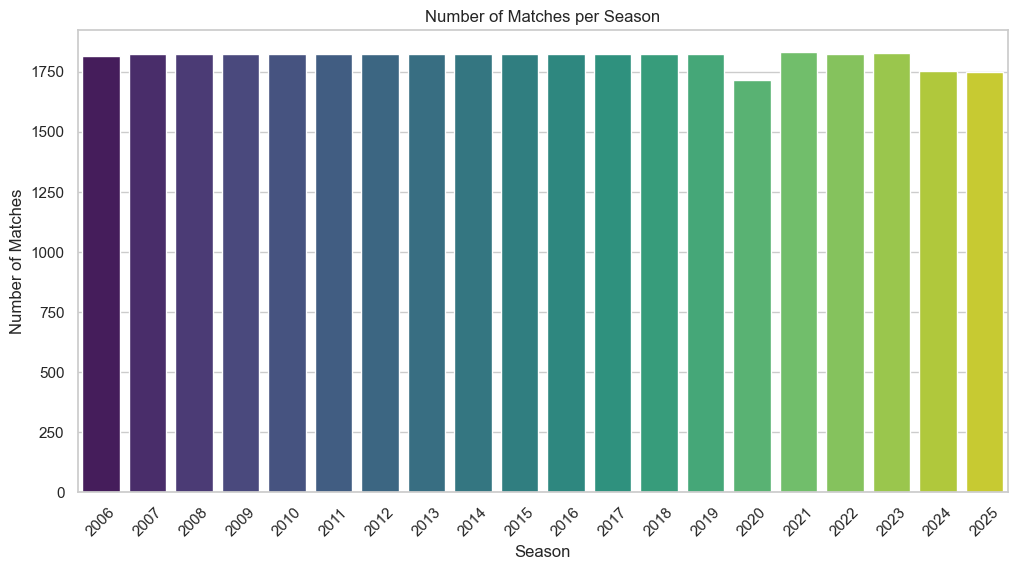

In [104]:
# plot number of games per season, sorted chronologically
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Sort seasons chronologically instead of by frequency
seasons_sorted = sorted(df['Season'].unique())

sns.countplot(data=df, x='Season', order=seasons_sorted, palette='viridis')
plt.xticks(rotation=45)
plt.title('Number of Matches per Season')
plt.xlabel('Season')
plt.ylabel('Number of Matches')

In [105]:
# delete rows without the xg
df_without_xg = df.dropna(subset=['home_xg', 'away_xg'])

In [106]:
# Compute the Pi rating using XG values instead of actual goals
# Initialize empty lists to store XG-based ratings
pi_home_rating_xg = []      # home team's home-venue rating BEFORE the match
pi_away_rating_xg = []      # away team's away-venue rating BEFORE the match
pi_exp_gd_xg = []           # transformed rating difference (expected GD)

# Process each league separately
for lg, group in df_without_xg.groupby("league", sort=False):
    _ratings.clear()        # fresh book per league

    for idx, row in group.iterrows():
        h, a = row["home_team"], row["away_team"]

        # Values BEFORE the match kicks off
        h_r = rating(h, "home")              # raw rating numbers
        a_r = rating(a, "away")
        gd = expected_score_diff(h, a)       # in goal-difference space

        # Store pre-match ratings
        pi_home_rating_xg.append(h_r)
        pi_away_rating_xg.append(a_r)
        pi_exp_gd_xg.append(gd)

        # Learn FROM the match result using XG instead of goals
        update_ratings(
            h, a,
            row["home_xg"],
            row["away_xg"]
        )

# Attach new columns to the dataframe
df_without_xg["pi_home_rating_xg"] = pi_home_rating_xg
df_without_xg["pi_away_rating_xg"] = pi_away_rating_xg
df_without_xg["pi_exp_gd_xg"] = pi_exp_gd_xg

/var/folders/k1/n035yq891w95hzqpmlll09k80000gn/T/ipykernel_90082/1848899924.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for lg, group in df_without_xg.groupby("league", sort=False):
/var/folders/k1/n035yq891w95hzqpmlll09k80000gn/T/ipykernel_90082/1848899924.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_xg["pi_home_rating_xg"] = pi_home_rating_xg
/var/folders/k1/n035yq891w95hzqpmlll09k80000gn/T/ipykernel_90082/1848899924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [108]:
df_without_xg

,week,day,date,time,home_team,score,away_team,attendance,venue,referee,...,goals_away,home_prob,draw_prob,away_prob,pi_home_rating,pi_away_rating,pi_exp_gd,pi_home_rating_xg,pi_away_rating_xg,pi_exp_gd_xg
3672,1.0,Fri,2017-08-18,20:30,bayern munich,3–1,leverkusen,75000.0,Allianz Arena,Tobias Stieler,...,1,0.759038,0.156798,0.084164,1.628591,0.458200,2.068851,0.000000,0.000000,0.000000
3673,1.0,Sat,2017-08-19,15:30,wolfsburg,0–3,dortmund,30000.0,Volkswagen Arena,Robert Hartmann,...,3,0.237842,0.246044,0.516114,0.322786,0.815456,-0.588766,0.000000,0.000000,0.000000
3674,1.0,Sat,2017-08-19,18:30,schalke 04,2–0,rb leipzig,61435.0,Veltins-Arena,Felix Zwayer,...,0,0.347456,0.284914,0.367631,0.713383,0.563746,0.187598,0.000000,0.000000,0.000000
3675,1.0,Sat,2017-08-19,15:30,mainz 05,0–1,hannover 96,28279.0,Opel Arena,Felix Brych,...,1,0.468795,0.280358,0.250847,0.368964,-0.551242,0.854036,0.000000,0.000000,0.000000
3676,1.0,Sat,2017-08-19,15:30,hertha bsc,2–0,stuttgart,44751.0,Olympiastadion Berlin,Sascha Stegemann,...,0,0.471081,0.276703,0.252216,0.326059,-0.335158,0.577719,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36241,38.0,Sun,2025-05-25,20:45,lazio,0–1,lecce,53000.0,Stadio Olimpico,Michael Fabbri,...,1,0.618233,0.255648,0.126120,0.936331,-0.130739,1.157236,0.750799,-0.234361,0.976443
36242,38.0,Sun,2025-05-25,20:45,udinese,2–3,fiorentina,20463.0,Bluenergy Stadium,Matteo Marcenaro,...,3,0.257880,0.265043,0.477077,0.357862,0.620762,-0.294256,0.025659,0.183032,-0.130939
36243,38.0,Sun,2025-05-25,20:45,atalanta,2–3,parma,23161.0,Gewiss Stadium,Livio Marinelli,...,3,0.540541,0.270270,0.189189,1.153645,-0.240581,1.626889,0.852640,-0.306339,1.189103
36244,38.0,Sun,2025-05-25,20:45,empoli,1–2,hellas verona,14025.0,Stadio Carlo Castellani - Computer Gross...,Daniele Doveri,...,2,0.485503,0.295853,0.218644,0.034341,0.006965,0.021348,-0.212990,-0.212495,-0.000448


In [ ]:
# safe both dataframes
df.to_csv('/Users/luisenriquekaiser/Documents/soccer_betting_forecast/data/processed/merged_data_with_pi.csv', index=False)
df_without_xg.to_csv('/Users/luisenriquekaiser/Documents/soccer_betting_forecast/data/processed/merged_data_with_pi_xg.csv', index=False)